###Car-pole problem using DQN and Double DQN.


#### **Cartpole Problem**####

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. (There is a slightly difference between v0 and v1. In this homework we are going to use v0.)

1. State: 

|Num|Observation|Min|Max|
|:-:|:-:|:-:|:-:|
|0|Cart Position|-4.8|4.8|
|1|Cart Velocity|-Inf|Inf|
|2|Pole Angle|-0.418 rad(-24 deg)|0.418 rad (24 deg)|
|3|Pole Angular Velocity|-Inf|Inf|

2. Actions:

|Num|Action|
|:-:|:-:|
|0|Push cart to the left|
|1|Push cart to the right|

3. Reward:

 Reward is 1 for every step taken, including the termination step

4. Initial position:

 All ininital states are chosen according to a uniform random value in [-0.05..0.05]

5. An episode Terminates when one of the following occurs:

  - Pole Angle is more than 12 degrees.
  - Cart reaches the edge of the display.
  - Episode length is greater than 195.


**Programming Language**

Python 3.6x with following libraries:
- Numpy
- pytorch
- Pandas
- Scikit-Learn
- gym


### Setup the Environment

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import torch.optim as optim
import random
import os
import time
import matplotlib.pyplot as plt

from torch.autograd import Variable

In [3]:
def eval_policy(agent,env_name,eval_episodes=10):
    eval_env = gym.make(env_name)
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = agent.policy(state)
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward
    avg_reward /= eval_episodes
    #print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward

### Define Network

In [4]:
class NETWORK(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int) -> None:

        super(NETWORK, self).__init__()

        self.layer1 = torch.nn.Sequential(
             torch.nn.Linear(input_dim, hidden_dim),
             torch.nn.ReLU()
         )

        self.layer2 = torch.nn.Sequential(
           torch.nn.Linear(hidden_dim, hidden_dim),
           torch.nn.ReLU()
        )

        self.adv = nn.Linear(hidden_dim,output_dim)
        self.val = nn.Linear(hidden_dim,1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = self.layer2(x)
        adv = self.adv(x)
        val = self.val(x)
        x = val + adv - adv.mean(1,keepdim=True)
        return x



class DQN(object):
    def __init__(self):
        self.action_dim = 2
        self.state_dim = 4
        self.hidden_dim = 64

        self.epsilon = 0.1  
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.01
        self.epsilon_max = 1.0
        self.gamma = 0.98           # discount factor
        self.beta = 0.001           # Learning Rate #0.3 

        # Behaviour Policy
        self.primal_network = NETWORK(self.state_dim, self.action_dim, self.hidden_dim)
        self.optimizer_primal = optim.Adam(self.primal_network.parameters(),self.beta)
        
        # Target Policy
        self.target_network = NETWORK(self.state_dim, self.action_dim, self.hidden_dim)

        self.replay_buffer = 50000     # All dataset
        self.batch_size = 64           # Randomly sample a batch from replay buffer
        self.target_update = 4 # No. of episodes
        self.episode_counter = 0

        self.memory = []

        self.counter = 0

    def select_action(self, states: np.ndarray) -> int:
        
        if (np.random.random()<self.epsilon):
            # Exploration
            with torch.no_grad():
                action = torch.tensor( [ [random.randrange(self.action_dim)] ] )   #int(np.random.choice(2, 1))
                action = action.item()
        else:
                # Exploitation
                action = self.policy(states)
        return action

    def policy(self, states: np.ndarray) -> int:  # policy is primal network?

        states = torch.FloatTensor(states).unsqueeze(0)
        with torch.no_grad():
                action = self.primal_network(states).max(1)[1].view(1,1)
        return action.item()

    def train(self,s0,a0,r,s1,sign):

        if sign==1:
            self.episode_counter += 1
            
        if (len(self.memory)>self.replay_buffer):
            del self.memory[0]

        self.memory.append((s0,a0,r,s1,sign))
        
        if len(self.memory)>=2*self.batch_size:

            if ( (self.episode_counter>=1) and (self.episode_counter % self.target_update == 0) ) :
                self.target_network.load_state_dict(self.primal_network.state_dict())
                self.episode_counter = 0
            
            transitions = random.sample(self.memory, self.batch_size)
            batch_state, batch_action, batch_reward, batch_next_state, batch_terminal = zip(*transitions)
            
            batch_state = torch.FloatTensor(batch_state)
            batch_action = torch.LongTensor(batch_action)
            batch_reward = torch.FloatTensor(batch_reward)
            batch_next_state = torch.FloatTensor(batch_next_state)
            batch_terminal = torch.FloatTensor(batch_terminal)

            Q_values = self.primal_network(batch_state)[range(self.batch_size), batch_action]  #.data

            with torch.no_grad():
                next_action = self.primal_network( batch_next_state ).max(1)[1]
                next_state_values = self.target_network(batch_next_state)[range(self.batch_size), next_action]
                expected_Q_values = batch_reward + self.gamma*(1 - batch_terminal)*next_state_values

            loss = (Q_values - expected_Q_values).pow(2).mean()

            self.optimizer_primal.zero_grad()
            loss.backward()
            self.optimizer_primal.step()

        if sign==1:
         	if self.epsilon > self.epsilon_min*self.epsilon_decay:
         		self.epsilon *= self.epsilon_decay
        	

### Start Training

In [5]:

env_name = 'CartPole-v0'
env = gym.make(env_name)
    
agent = DQN() # agent = DDQN()

start_time = time.time()

reward_plot = []

for i in range(10000):
    state,done = env.reset(),False
    episodic_reward = 0
    while not done:
        action = agent.select_action(np.squeeze(state))
        next_state, reward, done, info = env.step(action)
        env.render()
        episodic_reward += reward      
        sign = 1 if done else 0
        agent.train(state,action,reward,next_state,sign)
        state = next_state         
    #print (f'episode: {i}, reward: {episodic_reward}')         
    if i % 5 == 0:
        eval_reward = eval_policy(agent,env_name,eval_episodes=50)
        reward_plot.append(eval_reward)
        env.render()
        if eval_reward >= 195:
            print("Problem solved in {} episodes".format(i + 1))
            break

print('Complete')
env.render()
env.close()


print("----------- seconds ------------")
print(time.time() - start_time)

Evaluation over 50 episodes: 9.540
---------------------------------------
Evaluation over 50 episodes: 9.280
---------------------------------------
Evaluation over 50 episodes: 9.540
---------------------------------------
Evaluation over 50 episodes: 9.340
---------------------------------------
Evaluation over 50 episodes: 9.220
---------------------------------------
Evaluation over 50 episodes: 9.460
---------------------------------------
Evaluation over 50 episodes: 9.520
---------------------------------------


KeyboardInterrupt: 

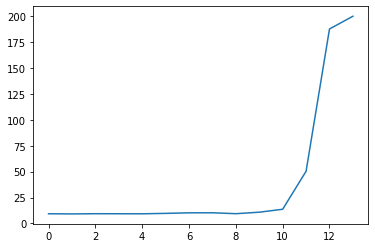

In [22]:
plt.plot(reward_plot)
plt.show()